In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

### I. Import Data

In [2]:
df = pd.read_csv('citrus.csv')
df.head(3)

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2


### II. Data Preprocessing

In [3]:
print ("Rows     : " , df.shape[0])  #get number of rows/observations
print ("Columns  : " , df.shape[1]) #get number of columns
print ("-"*60,"\n","Features: \n\n", df.columns.tolist()) #get name of columns/features
print ("-"*60,"\nMissing values:\n\n", df.isnull().sum().sort_values(ascending=False))
print ("-"*60,"\nPercent of missing:\n\n", round(df.isna().sum() / df.isna().count() * 100, 2)) # looking at columns with most Missing Values
print ("-"*60,"\nUnique values: \n\n", df.nunique())  #  count of unique values
print ("-"*60,'\nNumber of duplicated rows: ', df.duplicated().sum())

Rows     :  10000
Columns  :  6
------------------------------------------------------------ 
 Features: 

 ['name', 'diameter', 'weight', 'red', 'green', 'blue']
------------------------------------------------------------ 
Missing values:

 name        0
diameter    0
weight      0
red         0
green       0
blue        0
dtype: int64
------------------------------------------------------------ 
Percent of missing:

 name        0.0
diameter    0.0
weight      0.0
red         0.0
green       0.0
blue        0.0
dtype: float64
------------------------------------------------------------ 
Unique values: 

 name           2
diameter     940
weight      6627
red           75
green         80
blue          48
dtype: int64
------------------------------------------------------------ 
Number of duplicated rows:  0


### III. Explanatory Data Analysis

In [4]:
orange = (df[df.name == 'orange'])
grapefruit = (df[df.name == 'grapefruit'])

print(f'Number of Orange Records: {len(orange)}')
print(f'Number of Grapefruit Records: {len(grapefruit)}')

Number of Orange Records: 5000
Number of Grapefruit Records: 5000


The dataset appears to be balanced with 5,000 records for oranges and grapefruit. Imbalanced classes could lead to the model producing the wrong inference when deployed into the real world. The model could score highly on accuracy during testing but may be weak when used in production.

In [5]:
df.groupby('name').agg([np.mean, np.std]).T

name           grapefruit      orange
diameter mean   11.476946    8.474424
         std     1.221148    1.260665
weight   mean  197.296664  152.804920
         std    19.193190   18.669021
red      mean  150.862800  156.832800
         std    10.103148    9.890258
green    mean   70.033000   81.988200
         std    10.044924   10.090789
blue     mean   15.611200    7.115200
         std     9.271592    6.493779

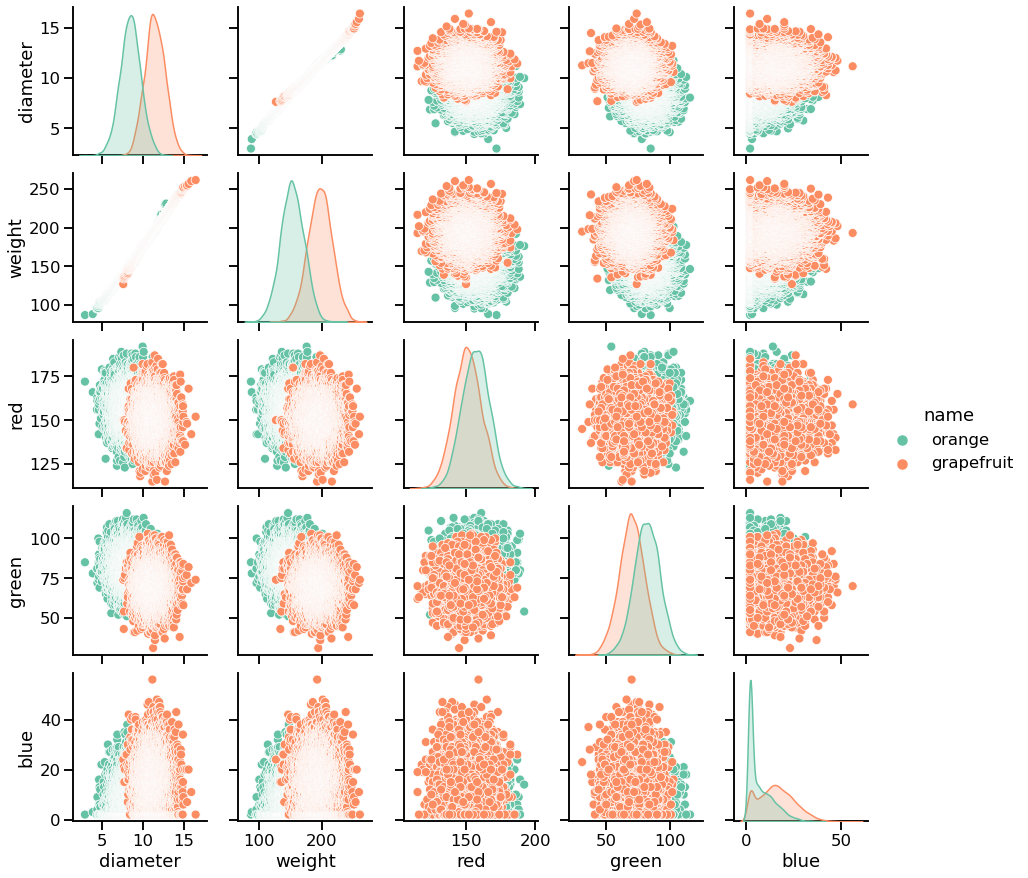

In [6]:
sns.pairplot(df, hue='name', palette='Set2')

In [7]:
def data_plot(data):
    Name=data.name.upper()
    fig,(ax_box,ax_dis)= plt.subplots(nrows=2,sharex=True,gridspec_kw = {"height_ratios": (.25, .75)},figsize=(8, 5))
    mean = data.mean()
    median = data.median()
    sns.set_theme(style="white")
    fig.suptitle('SPREAD OF DATA FOR '+ Name)
    sns.boxplot(x=data, showmeans=True, orient='h', color='green', ax=ax_box)
    ax_box.set(xlabel='Density')
    sns.despine(top=True, right=True, left=True)
    
    sns.distplot(data,kde=False,color='orange',ax=ax_dis)
    ax_dis.axvline(mean, color='r', linestyle='--',linewidth=2)
    ax_dis.axvline(median, color='g', linestyle='--',linewidth=2)
    plt.legend({'Mean':mean,'Median':median})

/Users/folara/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/folara/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/folara/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

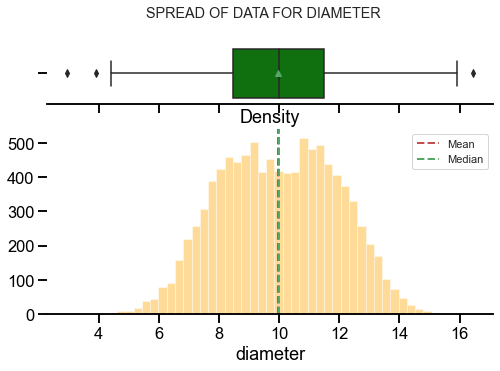

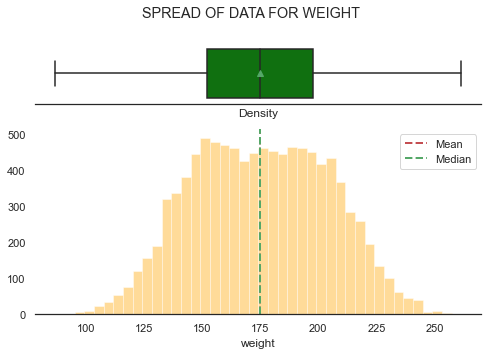

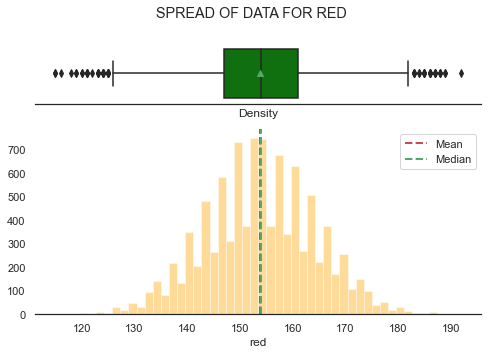

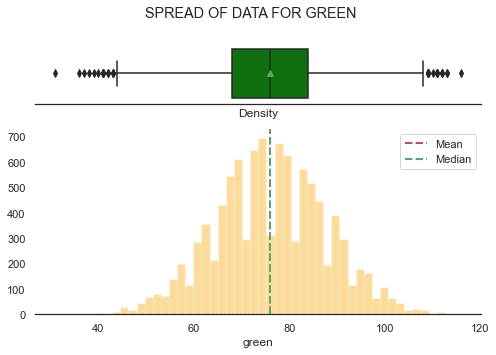

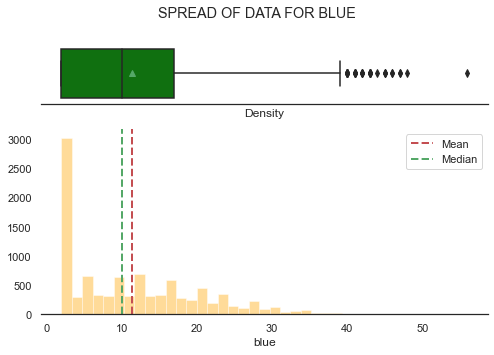

In [8]:
col_list = ['diameter', 'weight', 'red', 'green', 'blue']

for i in range(len(col_list)):
    data_plot(df[col_list[i]])

<AxesSubplot:xlabel='blue', ylabel='Density'>

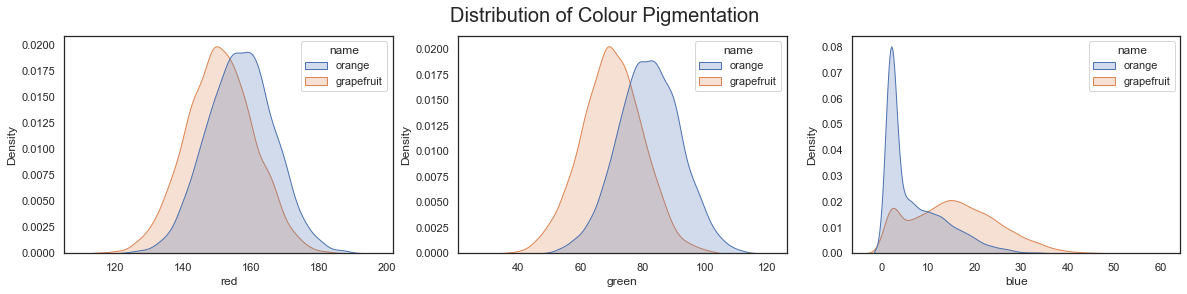

In [9]:
fig, axes = plt.subplots(1,3, figsize=(20,4))
fig.suptitle('Distribution of Colour Pigmentation', fontsize=20, fontweight=30)

sns.kdeplot(data=df, x='red', hue='name', fill=True, ax=axes[0])
sns.kdeplot(data=df, x='green', hue='name', fill=True, ax=axes[1])
sns.kdeplot(data=df, x='blue', hue='name', fill=True, ax=axes[2])

### IV. Decision Tree

A decision tree is a supervised machine learning algorithm that is used to predict the value of a target. Decision trees work by partitioning the dataset into smaller and smaller datasets, until each subset contains only one data point. Decision trees can be used in both a regression and classification context. 

In [10]:
df['fruit'] = df['name'].map({'orange':0, 'grapefruit':1})
df.head(2)

,name,diameter,weight,red,green,blue,fruit
0,orange,2.96,86.76,172,85,2,0
1,orange,3.91,88.05,166,78,3,0


In [11]:
x = df.iloc[:, 1:6]
y = df.fruit #fruit column will serve as the target coloumns

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.6, random_state=42)

In [13]:
print(f'Number of records in training dataset: {len(X_train)}')
print(f'Number of records in test dataset: {len(X_test)}')

Number of records in training dataset: 4000
Number of records in test dataset: 6000


In [14]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)

dtc_y_train_pred = dtc.predict(X_train)
dtc_y_test_pred = dtc.predict(X_test)

#### Confusion Matrix

A confusion matrix allows us to visualise how well a model performs on test data. The matrix above shows that only the results the model when tested on the test data. The rows of the confusion matrix correspond to the true labels and the columns correspond to the predicted labels. Diagonal and off-diagonal cells correspond to correctly and incorrectly classified observations, respectively. 

In [15]:
 def create_confusion_matrix(y_actual,y_predict,title):
    fig, ax = plt.subplots(1, 1)
    
    """
    This function creates a confusion matrix with the actual and predicted values
    y_actual = array of target values
    y_predict = array of predicted values
    title = chart title
    """
    
    cm = confusion_matrix(y_actual, y_predict, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False","True"])
    disp.plot(cmap='Blues', colorbar=True,ax=ax)
    plt.tick_params(axis='both', which='both', length=0) # remove both from statemement
    plt.grid(b=None,axis='both', which='both', visible=False)
    ax.set_title(title)
    

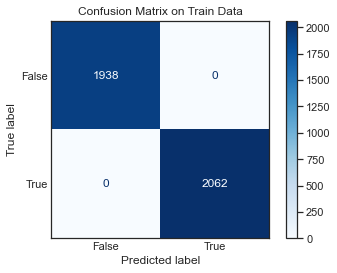

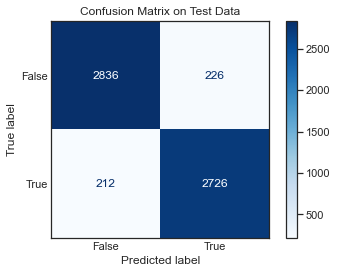

In [16]:
create_confusion_matrix(Y_train,dtc_y_train_pred,"Confusion Matrix on Train Data")
create_confusion_matrix(Y_test,dtc_y_test_pred,"Confusion Matrix on Test Data")

### V. Random Forest

The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

In [17]:
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)

rfc_y_train_pred = rfc.predict(X_train)
rfc_y_test_pred = rfc.predict(X_test)

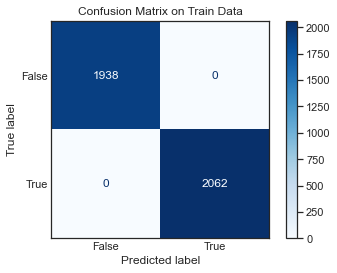

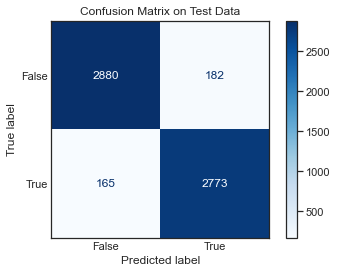

In [18]:
create_confusion_matrix(Y_train, rfc_y_train_pred,"Confusion Matrix on Train Data")
create_confusion_matrix(Y_test, rfc_y_test_pred,"Confusion Matrix on Test Data")

According to the confusion matrix above random forest model emerges as a better classifier to the decision tree. Only 334 records where incorrectly labelled with the random forest model while the decision tree incorrectly labelled 481 records.

### VI. Logistic Model

In [19]:
log = LogisticRegression()
log.fit(X_train, Y_train)

log_y_train_pred = log.predict(X_train)
log_y_test_pred = log.predict(X_test)

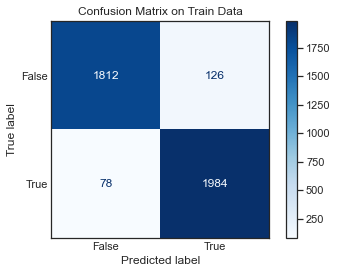

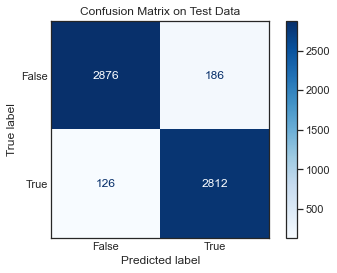

In [20]:
create_confusion_matrix(Y_train, log_y_train_pred,"Confusion Matrix on Train Data")
create_confusion_matrix(Y_test, log_y_test_pred,"Confusion Matrix on Test Data")

The logistic model seems to struggle to classify features during training compared to the two other models. 126 predictions were predicted as being as true when they were infact false while 78 predictions were labelled as false whilst being true. It’s not a cause of concern for now but highlights an opportunity for optimisation.

### VII. Conclusion

In order to select the most optimal model we need to compare the performance of each model. Classification reports are effective as the provide the precision, recall and f1-score for each class

- Precision represents how many predictions of a class belong in that class
- Recall measure how many values were accurately predicted in the correct class
- f1-score is the average between precision and recall

In [21]:
target_names = ['Orange', 'Passion Fruit']

In [22]:
print('- - - - - -  Decision Tree Classification Report - - - - - - ',"\n")
print(classification_report(Y_test, dtc_y_test_pred, target_names=target_names))
print("\n",'- - - - - -  Random Forest Classification Report - - - - - - ',"\n")
print(classification_report(Y_test, rfc_y_test_pred, target_names= target_names))
print("\n",'- - - - - -  Logistic Classification Report - - - - - - ',"\n")
print(classification_report(Y_test, log_y_test_pred, target_names= target_names))

- - - - - -  Decision Tree Classification Report - - - - - -  

               precision    recall  f1-score   support

       Orange       0.93      0.93      0.93      3062
Passion Fruit       0.92      0.93      0.93      2938

     accuracy                           0.93      6000
    macro avg       0.93      0.93      0.93      6000
 weighted avg       0.93      0.93      0.93      6000


 - - - - - -  Random Forest Classification Report - - - - - -  

               precision    recall  f1-score   support

       Orange       0.95      0.94      0.94      3062
Passion Fruit       0.94      0.94      0.94      2938

     accuracy                           0.94      6000
    macro avg       0.94      0.94      0.94      6000
 weighted avg       0.94      0.94      0.94      6000


 - - - - - -  Logistic Classification Report - - - - - -  

               precision    recall  f1-score   support

       Orange       0.96      0.94      0.95      3062
Passion Fruit       0.94      0.

From the three classification reports above it can be inferred that the logistic regression model is the most optimal model for classifying fruits. The logistic regression model outscores the other models by having the highest precision, recall and f1-score. 

Therefore, it's my recommendation that the farm should proceed with a logistic regression model for it new machine.